In [22]:
# load libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold, StratifiedKFold
from iterstrat.ml_stratifiers import RepeatedMultilabelStratifiedKFold
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelBinarizer, label_binarize
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline_imb
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVC, SVC, SVR
from sklearn.neural_network import MLPClassifier, MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [3]:
# import the dataset
data=pd.read_csv('school_grades_dataset.csv')
# categorize the ordinal predictors which were coded as numeric
data[data.select_dtypes(['int64']).loc[:,'Medu':'health'].columns]=data.select_dtypes(['int64']).loc[:,'Medu':'health'].apply(lambda x: x.astype('category'))

# remove G1, G2, G3 from predictor matrix, and dummy-code all the categorical predictors
x_cat=data.drop(['G1','G2','G3'], axis=1)
x_cat.rename(columns={'schoolsup':'schsupport'}, inplace=True)
x_cat=pd.get_dummies(x_cat)

# G3 is the outcome variable for regression, and create its binary and multinary versions for classification
y_cat=data['G3']
y_cat_bin=pd.cut(y_cat, [0,9.5,20], include_lowest=True)
y_cat_bin=y_cat_bin.cat.codes
y_cat_mul=pd.cut(y_cat, [0,9,11,13,15,20], include_lowest=True)
y_cat_mul=y_cat_mul.cat.codes

# split train and test sets for regression and classification, and leave test sets untouched
x_cat_train, x_cat_test, y_cat_train, y_cat_test=train_test_split(x_cat, y_cat, test_size=0.2, random_state=55)
x_cat_bin_train, x_cat_bin_test, y_cat_bin_train, y_cat_bin_test=train_test_split(x_cat, y_cat_bin, test_size=0.2, stratify=y_cat_bin, random_state=46)
x_cat_mul_train, x_cat_mul_test, y_cat_mul_train, y_cat_mul_test=train_test_split(x_cat, y_cat_mul, test_size=0.2, stratify=y_cat_mul, random_state=28)

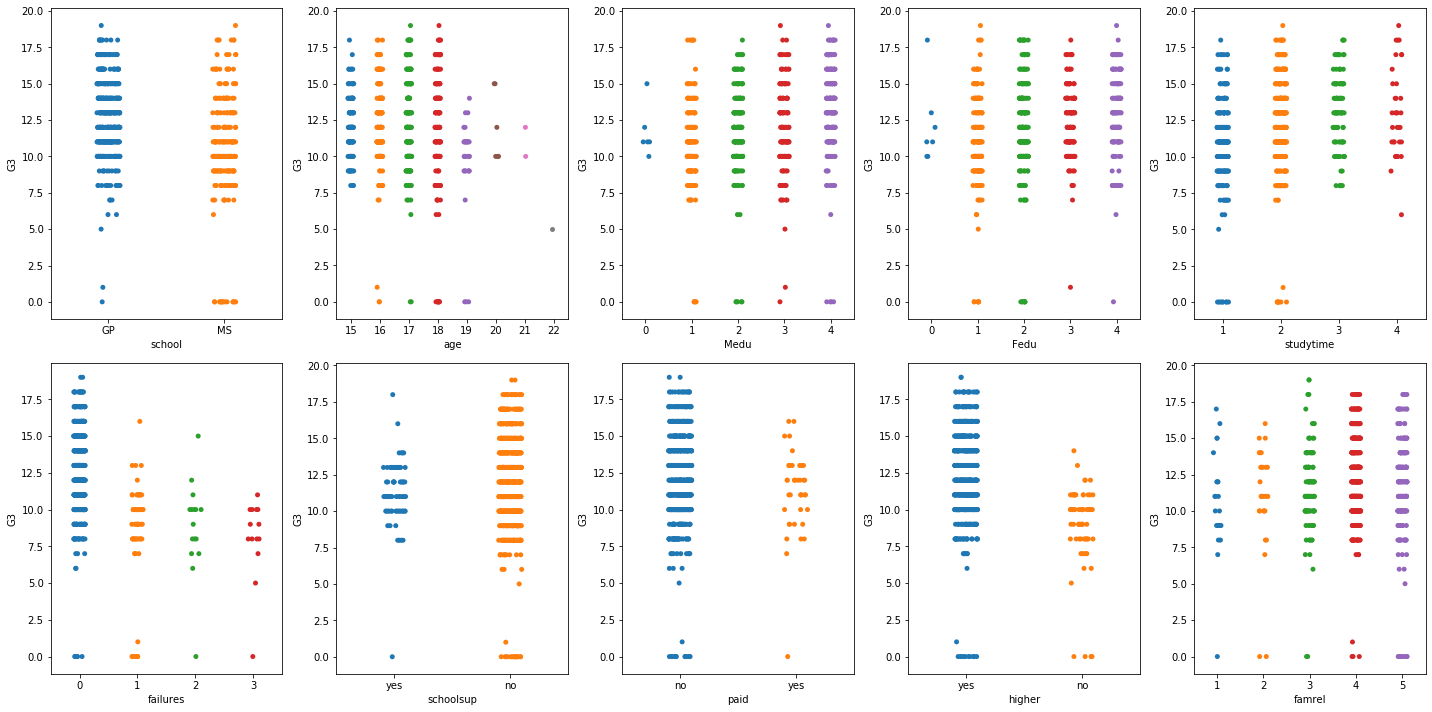

In [126]:
# visualize the data before going to the tasks; re-import the dataset for safety
# strip plots with jitters for potentially important features to explore regression possibility
data2=pd.read_csv('school_grades_dataset.csv')
data2=data2.drop(['G1','G2'], axis=1)
data2['G3_bin']=pd.cut(data2['G3'], [0,9.5,20], include_lowest=True).cat.codes

fig, axs = plt.subplots(2, 5, figsize=(20, 10))
sns.stripplot(x='school', y='G3', data=data2, ax=axs[0,0])
sns.stripplot(x='age', y='G3', data=data2, ax=axs[0,1])
sns.stripplot(x='Medu', y='G3', data=data2, ax=axs[0,2])
sns.stripplot(x='Fedu', y='G3', data=data2, ax=axs[0,3])
sns.stripplot(x='studytime', y='G3', data=data2, ax=axs[0,4])
sns.stripplot(x='failures', y='G3', data=data2, ax=axs[1,0])
sns.stripplot(x='schoolsup', y='G3', data=data2, ax=axs[1,1])
sns.stripplot(x='paid', y='G3', data=data2, ax=axs[1,2])
sns.stripplot(x='higher', y='G3', data=data2, ax=axs[1,3])
sns.stripplot(x='famrel', y='G3', data=data2, ax=axs[1,4])
plt.tight_layout()

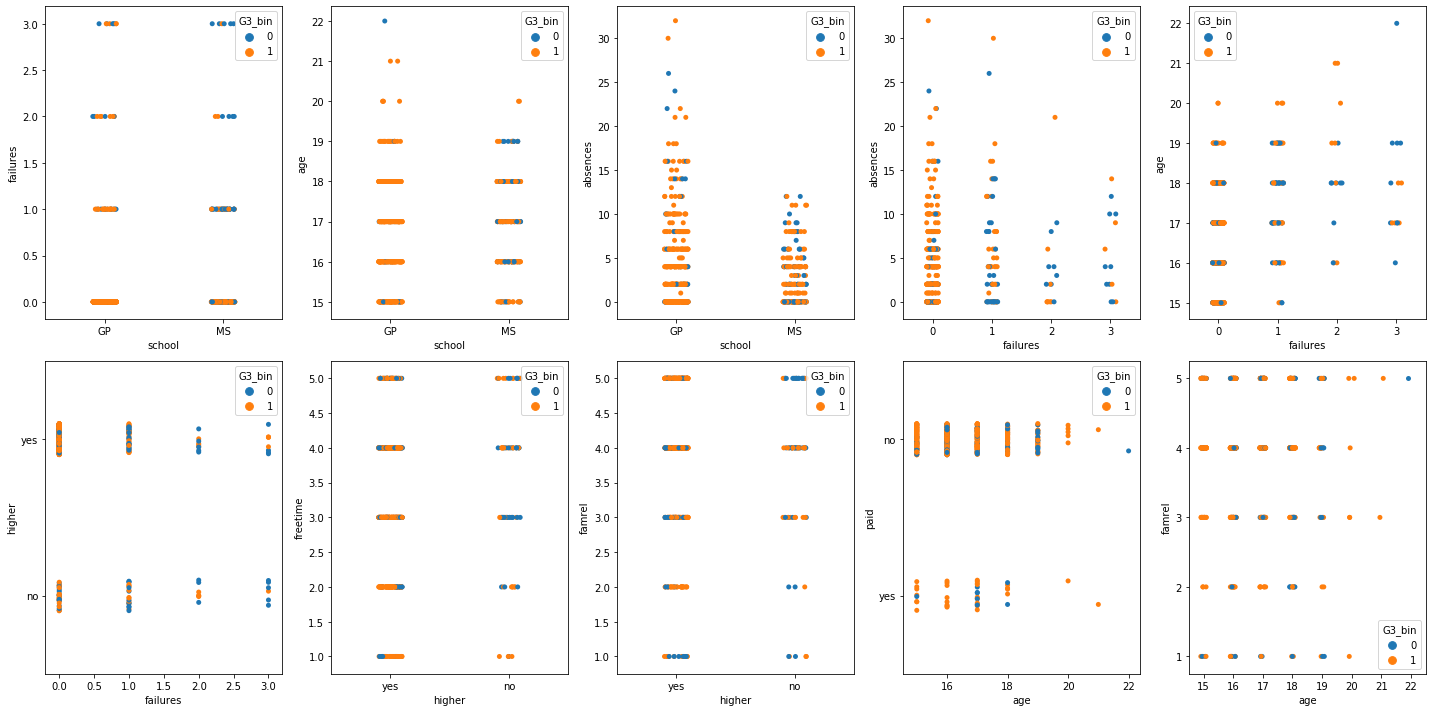

In [135]:
# strip plots with jitters for potentially important features to explore binary classification possibility
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
sns.stripplot(x='school', y='failures', hue='G3_bin', data=data2, ax=axs[0,0])
sns.stripplot(x='school', y='age', hue='G3_bin', data=data2, ax=axs[0,1])
sns.stripplot(x='school', y='absences', hue='G3_bin', data=data2, ax=axs[0,2])
sns.stripplot(x='failures', y='absences', hue='G3_bin', data=data2, ax=axs[0,3])
sns.stripplot(x='failures', y='age', hue='G3_bin', data=data2, ax=axs[0,4])
sns.stripplot(x='failures', y='higher', hue='G3_bin', data=data2, ax=axs[1,0])
sns.stripplot(x='higher', y='freetime', hue='G3_bin', data=data2, ax=axs[1,1])
sns.stripplot(x='higher', y='famrel', hue='G3_bin', data=data2, ax=axs[1,2])
sns.stripplot(x='age', y='paid', hue='G3_bin', data=data2, ax=axs[1,3])
sns.stripplot(x='age', y='famrel', hue='G3_bin', data=data2, ax=axs[1,4])
plt.tight_layout()

## 1. Regression task

In [4]:
# pipeline for (1) removing zero or near-zero variance predictors, (2) scaling, and (3) linear models (Ridge and Lasso)
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Regressor', SVR())])
param_grid_linear = [
{'Regressor': [Ridge(random_state=86)], 'Regressor__alpha': np.logspace(-3, 3, 7), 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Regressor': [Lasso(max_iter=10000, random_state=62)], 'Regressor__alpha': np.logspace(-3, 3, 7), 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
# repetead (2-times) 5-fold CV
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=14)
grid_search_linear_reg = GridSearchCV(pipe, param_grid_linear, n_jobs=-1, cv=kfold, iid=False).fit(x_cat_train, y_cat_train)

In [5]:
# pipeline for (1), (2), and (3) ensemble models (Random forest and Gradient boosting)
param_grid_ensemble = [
{'Regressor': [RandomForestRegressor(random_state=38)], 'Regressor__n_estimators': [100, 200, 400, 800],
 'Regressor__max_features': [5, 11, 20, 30], 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]},
{'Regressor': [GradientBoostingRegressor(random_state=29)], 'Regressor__n_estimators': [100, 200, 400, 800], 
 'Regressor__learning_rate': np.logspace(-3, 0, 4), 'Regressor__max_depth': [1, 2, 4], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_ensemble_reg = GridSearchCV(pipe, param_grid_ensemble, n_jobs=-1, cv=kfold, iid=False).fit(x_cat_train, y_cat_train)

In [6]:
# pipeline for (1), (2), and (3) SVR models (with linear and RBF kernels)
param_grid_svr = [
{'Regressor': [SVR(kernel='linear', max_iter=10000)], 'Regressor__C': np.logspace(-3, 3, 7), 
 'Regressor__epsilon': [0.01, 0.1, 0.5, 1, 5], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Regressor': [SVR(kernel='rbf', max_iter=10000)], 'Regressor__C': np.logspace(-3, 3, 7), 
 'Regressor__epsilon': [0.01, 0.1, 0.5, 1, 5], 'Regressor__gamma': np.logspace(-3, 3, 7),
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svr_reg = GridSearchCV(pipe, param_grid_svr, n_jobs=-1, cv=kfold, iid=False).fit(x_cat_train, y_cat_train)

In [7]:
# pipeline for (1), (2), and (3) neural network models (with 1 and 2 hidden layers)
param_grid_nn = [
{'Regressor': [MLPRegressor(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=75)], 
 'Regressor__alpha': np.logspace(-3, 2, 6), 'Regressor__hidden_layer_sizes': np.linspace(1, 21, 11).astype(int), 
 'Regressor__learning_rate_init': np.logspace(-2, 0, 3), 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Regressor': [MLPRegressor(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=75)], 
 'Regressor__alpha': np.logspace(-3, 2, 6), 'Regressor__learning_rate_init': np.logspace(-2, 0, 3), 
 'Regressor__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(np.linspace(1,21,6).astype(int),np.linspace(1,21,6).astype(int))))], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_nn_reg = GridSearchCV(pipe, param_grid_nn, n_jobs=-1, cv=kfold, iid=False).fit(x_cat_train, y_cat_train)

In [8]:
# the best CV score, test scores, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV score Linear={}'.format(grid_search_linear_reg.best_score_))
print('Best Test score Linear={}'.format(grid_search_linear_reg.score(x_cat_test, y_cat_test)))
y_pred = grid_search_linear_reg.predict(x_cat_test)
print('Best Test RMSE Linear={}'.format(np.sqrt(mean_squared_error(y_cat_test, y_pred))))
print('Best parameters Linear: {}'.format(grid_search_linear_reg.best_params_))

# the best CV score, test scores, and best parameters for ensemble models
print('\n\nBest CV score Ensemble={}'.format(grid_search_ensemble_reg.best_score_))
print('Best Test score Ensemble={}'.format(grid_search_ensemble_reg.score(x_cat_test, y_cat_test)))
y_pred = grid_search_ensemble_reg.predict(x_cat_test)
print('Best Test RMSE Ensemble={}'.format(np.sqrt(mean_squared_error(y_cat_test, y_pred))))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_reg.best_params_))

# the best CV score, test scores, and best parameters for SVR models
print('\n\nBest CV score SVR={}'.format(grid_search_svr_reg.best_score_))
print('Best Test score SVR={}'.format(grid_search_svr_reg.score(x_cat_test, y_cat_test)))
y_pred = grid_search_svr_reg.predict(x_cat_test)
print('Best Test RMSE SVR={}'.format(np.sqrt(mean_squared_error(y_cat_test, y_pred))))
print('Best parameters SVR: {}'.format(grid_search_svr_reg.best_params_))

# the best CV score, test scores, and best parameters for neural network models
print('\n\nBest CV score NN={}'.format(grid_search_nn_reg.best_score_))
print('Best Test score NN={}'.format(grid_search_nn_reg.score(x_cat_test, y_cat_test)))
y_pred = grid_search_nn_reg.predict(x_cat_test)
print('Best Test RMSE NN={}'.format(np.sqrt(mean_squared_error(y_cat_test, y_pred))))
print('Best parameters NN: {}'.format(grid_search_nn_reg.best_params_))

Best CV score Linear=0.2951723559121788
Best Test score Linear=0.20786073523080073
Best Test RMSE Linear=2.688818934702194
Best parameters Linear: {'Regressor': Ridge(alpha=100.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=86, solver='auto', tol=0.001), 'Regressor__alpha': 100.0, 'nearzerovar__threshold': 0.01, 'preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1))}


Best CV score Ensemble=0.3353895100765459
Best Test score Ensemble=0.2450642717463889
Best Test RMSE Ensemble=2.624918217590495
Best parameters Ensemble: {'Regressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=800,
                      n_jobs=None, oob_score=False, random_state=38, verbo

In [4]:
# re-run only the best model based on the CV result
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Regressor', SVR())])
param_grid_ensemble = [
{'Regressor': [RandomForestRegressor(random_state=38)], 'Regressor__n_estimators': [800], 
 'Regressor__max_features': [20], 'preprocessing': [None], 'nearzerovar__threshold': [0.01]}]
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=14)
grid_search_ensemble_reg = GridSearchCV(pipe, param_grid_ensemble, n_jobs=-1, cv=kfold, iid=False).fit(x_cat_train, y_cat_train)

# re-check the results
print('Best CV score Ensemble={}'.format(grid_search_ensemble_reg.best_score_))
print('Best model traning score Ensemble={}'.format(grid_search_ensemble_reg.score(x_cat_train, y_cat_train)))
print('Best model test score Ensemble={}'.format(grid_search_ensemble_reg.score(x_cat_test, y_cat_test)))
y_pred = grid_search_ensemble_reg.predict(x_cat_test)
print('Best model test RMSE Ensemble={}'.format(np.sqrt(mean_squared_error(y_cat_test, y_pred))))

Best CV score Ensemble=0.3353895100765459
Best model traning score Ensemble=0.910431083059393
Best model test score Ensemble=0.2450642717463889
Best model test RMSE Ensemble=2.624918217590495


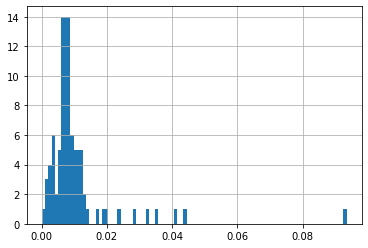

In [10]:
# get feature importance plot
bin_booleans = grid_search_ensemble_reg.best_estimator_.named_steps['nearzerovar'].get_support()
feat_importances = pd.Series(grid_search_ensemble_reg.best_estimator_.named_steps['Regressor'].feature_importances_, index=x_cat_bin_train.columns[bin_booleans])

# histogram for all the features
feat_importances.hist(bins=97)
plt.show()

In [13]:
# get the number of most important features > 0.015
print("the number of important features={}".format((feat_importances>0.015).sum()))

the number of important features=10


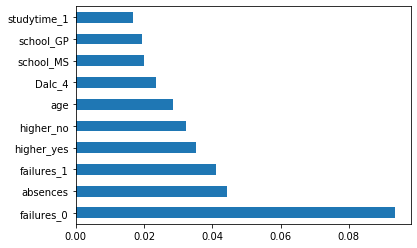

In [14]:
# get feature importance plot for the top 10 features
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## 2-1. Binary classification task with imbalanced classes

In [4]:
# value counts of binary outcome, showing that it is imbalanced
y_cat_bin.value_counts()

1    549
0    100
dtype: int64

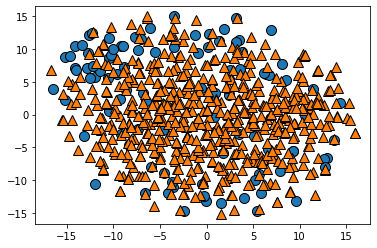

In [14]:
# T-SNE to visualize the data space and explore the possibility of classification
tsne = TSNE(perplexity=50, n_iter=5000, random_state=42)
x_tsne = tsne.fit_transform(x_cat)
mglearn.discrete_scatter(x_tsne[:, 0], x_tsne[:, 1], y_cat_bin)

In [90]:
# pipeline for (1) removing zero or near-zero variance predictors, (2) scaling, and (3) logistic regression models (Ridge and Lasso)
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_linear = [
{'Classifier': [LogisticRegression(solver='saga', max_iter=10000, random_state=15)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__penalty': ['l1', 'l2'], 'Classifier__class_weight': [None, 'balanced'],
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=29)
grid_search_linear_bin = GridSearchCV(pipe, param_grid_linear, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [91]:
# pipeline for (1), (2), and (3) ensemble models (Random forest and Gradient boosting)
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__max_features': [5, 11, 20, 30], 'Classifier__class_weight': [None, 'balanced'], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [GradientBoostingClassifier(random_state=29)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__learning_rate': np.logspace(-3, 0, 4), 'Classifier__max_depth': [1, 2, 4], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_ensemble_bin = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [92]:
# pipeline for (1), (2), and (3) SVM models (with linear and RBF kernels)
param_grid_svm = [
{'Classifier': [SVC(kernel='linear', max_iter=10000, random_state=51)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__class_weight': [None, 'balanced'],
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [SVC(kernel='rbf', max_iter=10000, random_state=27)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__gamma': np.logspace(-3, 3, 7), 'Classifier__class_weight': [None, 'balanced'], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svm_bin = GridSearchCV(pipe, param_grid_svm, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [93]:
# pipeline for (1), (2), and (3) neural network models (with 1 and 2 hidden layers)
param_grid_nn = [
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=93)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__hidden_layer_sizes': np.linspace(1, 21, 11).astype(int), 
 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=87)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 
 'Classifier__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(np.linspace(1,21,6).astype(int),np.linspace(1,21,6).astype(int))))], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_nn_bin = GridSearchCV(pipe, param_grid_nn, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [157]:
# the best CV score, test scores and classification report, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV AUC Linear={}'.format(grid_search_linear_bin.best_score_))
print('Best Test AUC Linear={}'.format(grid_search_linear_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_linear_bin.predict(x_cat_bin_test)
print('Best Test Accuracy Linear={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report Linear:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters Linear: {}'.format(grid_search_linear_bin.best_params_))

# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV AUC Ensemble={}'.format(grid_search_ensemble_bin.best_score_))
print('Best Test AUC Ensemble={}'.format(grid_search_ensemble_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_ensemble_bin.predict(x_cat_bin_test)
print('Best Test Accuracy Ensemble={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_bin.best_params_))

# the best CV score, test scores and classification report, and best parameters for SVM models
print('\n\nBest CV AUC SVM={}'.format(grid_search_svm_bin.best_score_))
print('Best Test AUC SVM={}'.format(grid_search_svm_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_svm_bin.predict(x_cat_bin_test)
print('Best Test Accuracy SVM={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report SVM:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_bin.best_params_))

# the best CV score, test scores and classification report, and best parameters for neural network models
print('\n\nBest CV AUC NN={}'.format(grid_search_nn_bin.best_score_))
print('Best Test AUC NN={}'.format(grid_search_nn_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_nn_bin.predict(x_cat_bin_test)
print('Best Test Accuracy NN={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report NN:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters NN: {}'.format(grid_search_nn_bin.best_params_))

Best CV AUC Linear=0.8344272466039708
Best Test AUC Linear=0.8150000000000001
Best Test Accuracy Linear=0.823076923076923
Classification Report Linear:
               precision    recall  f1-score   support

           0       0.45      0.65      0.53        20
           1       0.93      0.85      0.89       110

    accuracy                           0.82       130
   macro avg       0.69      0.75      0.71       130
weighted avg       0.86      0.82      0.84       130

Best parameters Linear: {'Classifier': LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='warn', n_jobs=None,
                   penalty='l1', random_state=15, solver='saga', tol=0.0001,
                   verbose=0, warm_start=False), 'Classifier__C': 0.1, 'Classifier__class_weight': 'balanced', 'Classifier__penalty': 'l1', 'nearzerovar__threshold': 0.01, 'preprocessing': MinMaxSca

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [5]:
# re-run only the best model based on the CV result
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [100], 
 'Classifier__max_features': [20], 'Classifier__class_weight': [None], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01]}]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=29)
grid_search_ensemble_bin = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

# re-check the results
print('Best CV AUC Ensemble={}'.format(grid_search_ensemble_bin.best_score_))
print('Best model training AUC Ensemble={}'.format(grid_search_ensemble_bin.score(x_cat_bin_train, y_cat_bin_train)))
print('Best model test AUC Ensemble={}'.format(grid_search_ensemble_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_ensemble_bin.predict(x_cat_bin_test)
print('Best model test Accuracy Ensemble={}'.format(np.mean(y_cat_bin_test==y_pred)))

Best CV AUC Ensemble=0.847517061781609
Best model training AUC Ensemble=1.0
Best model test AUC Ensemble=0.7945454545454546
Best model test Accuracy Ensemble=0.8692307692307693


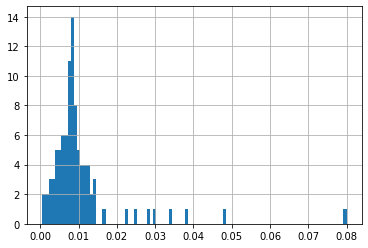

In [6]:
# get feature importance plot
bin_booleans = grid_search_ensemble_bin.best_estimator_.named_steps['nearzerovar'].get_support()
feat_importances = pd.Series(grid_search_ensemble_bin.best_estimator_.named_steps['Classifier'].feature_importances_, index=x_cat_bin_train.columns[bin_booleans])

# histogram for all the features
feat_importances.hist(bins=96)
plt.show()

In [7]:
# get the number of most important features > 0.015
print("the number of important features={}".format((feat_importances>0.015).sum()))

the number of important features=9


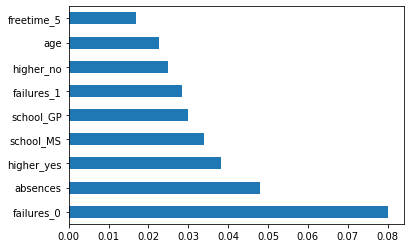

In [8]:
# get feature importance plot for the top 9 features
feat_importances.nlargest(9).plot(kind='barh')
plt.show()

## 2-2. Binary classification task with oversampling (SMOTE)

In [79]:
# just to test SMOTE for balancing the two classes
# actual SMOTE step is incorporated into the pipelines below
smote=SMOTE(random_state=35)
x_smote_bin, y_smote_bin = smote.fit_sample(x_cat, y_cat_bin)
print(np.bincount(y_smote))

[549 549]


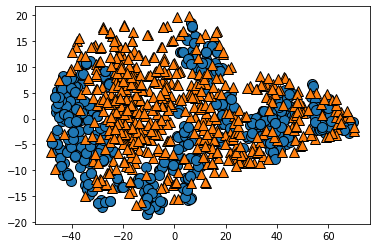

In [39]:
# T-SNE to visualize the data space and explore the possibility of classification
tsne = TSNE(perplexity=50, n_iter=5000, random_state=42)
x_tsne = tsne.fit_transform(x_smote_bin)
mglearn.discrete_scatter(x_tsne[:, 0], x_tsne[:, 1], y_smote_bin)

In [80]:
# pipeline for (1) SMOTE, (2) removing zero or near-zero variance predictors, (3) scaling, and (4) logistic regression models (Ridge and Lasso)
pipe = Pipeline_imb([('smote', SMOTE()), ('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_linear = [
{'Classifier': [LogisticRegression(solver='saga', max_iter=10000, random_state=15)], 
 'Classifier__C': np.logspace(-3, 3, 7), 'Classifier__penalty': ['l1', 'l2'], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=29)
grid_search_linear_bin_smote = GridSearchCV(pipe, param_grid_linear, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [81]:
# pipeline for (1), (2), (3), and (4) ensemble models (Random forest and Gradient boosting)
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__max_features': [5, 11, 20, 30], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [GradientBoostingClassifier(random_state=29)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__learning_rate': np.logspace(-3, 0, 4), 'Classifier__max_depth': [1, 2, 4], 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_ensemble_bin_smote = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [82]:
# pipeline for (1), (2), (3), and (4) SVM models (with linear and RBF kernels)
param_grid_svm = [
{'Classifier': [SVC(kernel='linear', max_iter=10000, random_state=51)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [StandardScaler(), MinMaxScaler()], 
 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [SVC(kernel='rbf', max_iter=10000, random_state=27)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__gamma': np.logspace(-3, 3, 7), 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svm_bin_smote = GridSearchCV(pipe, param_grid_svm, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [83]:
# pipeline for (1), (2), (3), and (4) neural network models (with 1 and 2 hidden layers)
param_grid_nn = [
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=93)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__hidden_layer_sizes': np.linspace(1, 21, 11).astype(int), 
 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=87)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 
 'Classifier__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(np.linspace(1,21,6).astype(int),np.linspace(1,21,6).astype(int))))], 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [StandardScaler(), MinMaxScaler()], 
 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_nn_bin_smote = GridSearchCV(pipe, param_grid_nn, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [158]:
# the best CV score, test scores and classification report, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV AUC Linear={}'.format(grid_search_linear_bin_smote.best_score_))
print('Best Test AUC Linear={}'.format(grid_search_linear_bin_smote.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_linear_bin_smote.predict(x_cat_bin_test)
print('Best Test Accuracy Linear={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report Linear:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters Linear: {}'.format(grid_search_linear_bin_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV AUC Ensemble={}'.format(grid_search_ensemble_bin_smote.best_score_))
print('Best Test AUC Ensemble={}'.format(grid_search_ensemble_bin_smote.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_ensemble_bin_smote.predict(x_cat_bin_test)
print('Best Test Accuracy Ensemble={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_bin_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for SVM models
print('\n\nBest CV AUC SVM={}'.format(grid_search_svm_bin_smote.best_score_))
print('Best Test AUC SVM={}'.format(grid_search_svm_bin_smote.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_svm_bin_smote.predict(x_cat_bin_test)
print('Best Test Accuracy SVM={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report SVM:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_bin_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for neural network models
print('\n\nBest CV AUC NN={}'.format(grid_search_nn_bin_smote.best_score_))
print('Best Test AUC NN={}'.format(grid_search_nn_bin_smote.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_nn_bin_smote.predict(x_cat_bin_test)
print('Best Test Accuracy NN={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report NN:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters NN: {}'.format(grid_search_nn_bin_smote.best_params_))

Best CV AUC Linear=0.823913433908046
Best Test AUC Linear=0.7999999999999999
Best Test Accuracy Linear=0.8384615384615385
Classification Report Linear:
               precision    recall  f1-score   support

           0       0.47      0.40      0.43        20
           1       0.89      0.92      0.91       110

    accuracy                           0.84       130
   macro avg       0.68      0.66      0.67       130
weighted avg       0.83      0.84      0.83       130

Best parameters Linear: {'Classifier': LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=15, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), 'Classifier__C': 0.01, 'Classifier__penalty': 'l2', 'nearzerovar__threshold': 0.05, 'preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)), 'smote

In [4]:
# re-run only the best model based on the CV result
pipe = Pipeline_imb([('smote', SMOTE()), ('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [400], 
 'Classifier__max_features': [20], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.05]}]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=29)
grid_search_ensemble_bin = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

# re-check the results
print('Best CV AUC Ensemble={}'.format(grid_search_ensemble_bin.best_score_))
print('Best model training AUC Ensemble={}'.format(grid_search_ensemble_bin.score(x_cat_bin_train, y_cat_bin_train)))
print('Best model test AUC Ensemble={}'.format(grid_search_ensemble_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_ensemble_bin.predict(x_cat_bin_test)
print('Best model test Accuracy Ensemble={}'.format(np.mean(y_cat_bin_test==y_pred)))

Best CV AUC Ensemble=0.8411356289184952
Best model training AUC Ensemble=1.0
Best model test AUC Ensemble=0.8306818181818182
Best model test Accuracy Ensemble=0.8846153846153846


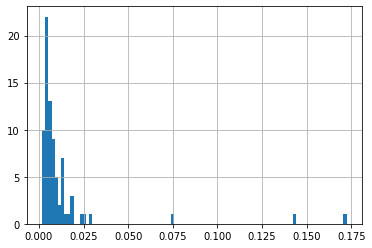

In [6]:
# get feature importance plot
bin_booleans = grid_search_ensemble_bin.best_estimator_.named_steps['nearzerovar'].get_support()
feat_importances = pd.Series(grid_search_ensemble_bin.best_estimator_.named_steps['Classifier'].feature_importances_, index=x_cat_bin_train.columns[bin_booleans])

# histogram for all the features
feat_importances.hist(bins=97)
plt.show()

In [7]:
# get the number of most important features > 0.015
print("the number of important features={}".format((feat_importances>0.015).sum()))

the number of important features=11


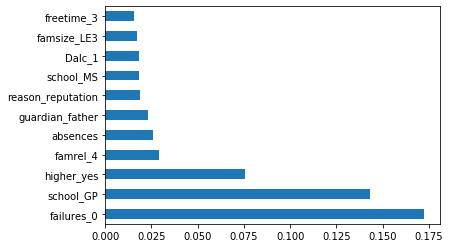

In [9]:
# get feature importance plot for the top 9 features
feat_importances.nlargest(11).plot(kind='barh')
plt.show()

## 3-1. Multinary classification task with imbalanced classes and accuracy metric

In [10]:
# value counts of the multinary outcome, showing that it is imbalanced
y_cat_mul.value_counts()

1    201
2    154
3    112
0    100
4     82
dtype: int64

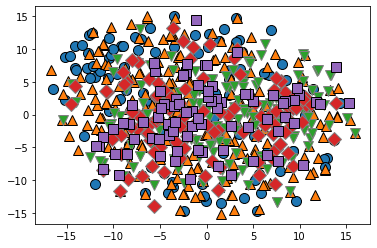

In [18]:
# T-SNE to visualize the data space and explore the possibility of classification
tsne = TSNE(perplexity=50, n_iter=5000, random_state=42)
x_tsne = tsne.fit_transform(x_cat)
mglearn.discrete_scatter(x_tsne[:, 0], x_tsne[:, 1], y_cat_mul)

In [95]:
# pipeline for (1) removing zero or near-zero variance predictors, (2) scaling, and (3) logistic regression models (Ridge and Lasso)
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_linear = [
{'Classifier': [LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000, random_state=15)], 
 'Classifier__C': np.logspace(-3, 3, 7), 'Classifier__penalty': ['l1', 'l2'], 'Classifier__class_weight': [None, 'balanced'],
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=61)
grid_search_linear_mul = GridSearchCV(pipe, param_grid_linear, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [96]:
# pipeline for (1), (2), and (3) ensemble models (Random forest and Gradient boosting)
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__max_features': [5, 11, 20, 30], 'Classifier__class_weight': [None, 'balanced'], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [GradientBoostingClassifier(random_state=29)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__learning_rate': np.logspace(-3, 0, 4), 'Classifier__max_depth': [1, 2, 4], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_ensemble_mul = GridSearchCV(pipe, param_grid_ensemble, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [97]:
# pipeline for (1), (2), and (3) SVM models (with linear and RBF kernels)
param_grid_svm = [
{'Classifier': [SVC(kernel='linear', max_iter=10000, random_state=51)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__class_weight': [None, 'balanced'],
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [SVC(kernel='rbf', max_iter=10000, random_state=27)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__gamma': np.logspace(-3, 3, 7), 'Classifier__class_weight': [None, 'balanced'], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svm_mul = GridSearchCV(pipe, param_grid_svm, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [98]:
# pipeline for (1), (2), and (3) neural network models (with 1 and 2 hidden layers)
param_grid_nn = [
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=93)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__hidden_layer_sizes': np.linspace(1, 21, 11).astype(int), 
 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=87)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 
 'Classifier__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(np.linspace(1,21,6).astype(int),np.linspace(1,21,6).astype(int))))], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_nn_mul = GridSearchCV(pipe, param_grid_nn, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [149]:
# the best CV score, test scores and classification report, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV Accuracy Linear={}'.format(grid_search_linear_mul.best_score_))
print('Best Test Accuracy Linear={}'.format(grid_search_linear_mul.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_linear_mul.predict(x_cat_mul_test)
print('Classification Report Linear:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters Linear: {}'.format(grid_search_linear_mul.best_params_))

# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV Accuracy Ensemble={}'.format(grid_search_ensemble_mul.best_score_))
print('Best Test Accuracy Ensemble={}'.format(grid_search_ensemble_mul.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_ensemble_mul.predict(x_cat_mul_test)
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_mul.best_params_))

# the best CV score, test scores and classification report, and best parameters for SVM models
print('\n\nBest CV Accuracy SVM={}'.format(grid_search_svm_mul.best_score_))
print('Best Test Accuracy SVM={}'.format(grid_search_svm_mul.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_svm_mul.predict(x_cat_mul_test)
print('Classification Report SVM:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_mul.best_params_))

# the best CV score, test scores and classification report, and best parameters for neural network models
print('\n\nBest CV Accuracy NN={}'.format(grid_search_nn_mul.best_score_))
print('Best Test Accuracy NN={}'.format(grid_search_nn_mul.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_nn_mul.predict(x_cat_mul_test)
print('Classification Report NN:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters NN: {}'.format(grid_search_nn_mul.best_params_))

Best CV Accuracy Linear=0.36807826587171
Best Test Accuracy Linear=0.38461538461538464
Classification Report Linear:
               precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.37      0.80      0.51        40
           2       0.38      0.48      0.42        31
           3       0.67      0.09      0.15        23
           4       0.00      0.00      0.00        16

    accuracy                           0.38       130
   macro avg       0.48      0.28      0.24       130
weighted avg       0.48      0.38      0.30       130

Best parameters Linear: {'Classifier': LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=15, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), 'Classifier__C': 0.0

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best Test Accuracy SVM=0.38461538461538464
Classification Report SVM:
               precision    recall  f1-score   support

           0       0.45      0.25      0.32        20
           1       0.42      0.62      0.50        40
           2       0.34      0.39      0.36        31
           3       0.29      0.22      0.25        23
           4       0.43      0.19      0.26        16

    accuracy                           0.38       130
   macro avg       0.39      0.33      0.34       130
weighted avg       0.38      0.38      0.37       130

Best parameters SVM: {'Classifier': SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=27, shrinking=True, tol=0.001,
    verbose=False), 'Classifier__C': 10.0, 'Classifier__class_weight': None, 'Classifier__gamma': 0.1, 'nearzerovar__threshold': 0.05, 'preprocessing': MinMaxScaler(copy=True, feature_range=(0, 1)

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [11]:
# re-run only the best model based on the CV result
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [800], 
 'Classifier__max_features': [5], 'Classifier__class_weight': [None], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.05]}]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=61)
# in multi-class setting where prediction is assigned to only one class, accuracy and f1-micro are the same, as the below result shows
# we specified this to 'f1_micro' to compare it not only with 3-2 result, but also with 3-3 result
grid_search_ensemble_mul = GridSearchCV(pipe, param_grid_ensemble, scoring='f1_micro', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

# re-check the results
print('Best CV Accuracy Ensemble={}'.format(grid_search_ensemble_mul.best_score_))
print('Best model training Accuracy Ensemble={}'.format(grid_search_ensemble_mul.score(x_cat_mul_train, y_cat_mul_train)))
print('Best model test Accuracy Ensemble={}'.format(grid_search_ensemble_mul.score(x_cat_mul_test, y_cat_mul_test)))

Best CV Accuracy Ensemble=0.38353072900218466
Best model training Accuracy Ensemble=1.0
Best model test Accuracy Ensemble=0.3230769230769231


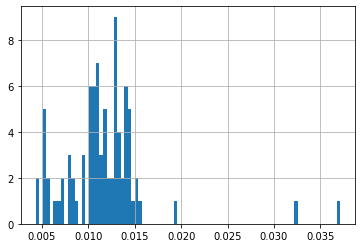

In [14]:
# get feature importance plot
bin_booleans = grid_search_ensemble_mul.best_estimator_.named_steps['nearzerovar'].get_support()
feat_importances = pd.Series(grid_search_ensemble_mul.best_estimator_.named_steps['Classifier'].feature_importances_, index=x_cat_mul_train.columns[bin_booleans])

# histogram for all the features
feat_importances.hist(bins=86)
plt.show()

In [23]:
# get the number of most important features > 0.014
print("the number of important features={}".format((feat_importances>0.014).sum()))

the number of important features=15


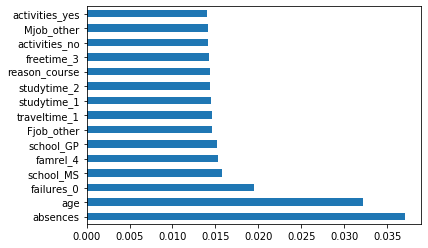

In [24]:
# get feature importance plot for the top 15 features
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

## 3-2. Multinary classification task with oversampling (SMOTE) and accuracy metric

In [61]:
# just to test SMOTE for balancing the multinary classes
# actual SMOTE is incorporated into the pipelines below
smote=SMOTE(random_state=35)
x_smote_mul, y_smote_mul = smote.fit_sample(x_cat, y_cat_mul)
print(np.bincount(y_smote_mul))

[201 201 201 201 201]


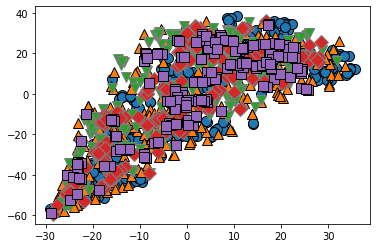

In [63]:
# T-SNE to visualize the data space and explore the possibility of classification
tsne = TSNE(perplexity=50, n_iter=5000, random_state=42)
x_tsne = tsne.fit_transform(x_smote_mul)
mglearn.discrete_scatter(x_tsne[:, 0], x_tsne[:, 1], y_smote_mul)

In [85]:
# pipeline for (1) SMOTE, (2) removing zero or near-zero variance predictors, (3) scaling, and (4) logistic regression models (Ridge and Lasso)
pipe = Pipeline_imb([('smote', SMOTE()), ('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_linear = [
{'Classifier': [LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10000, random_state=15)], 
 'Classifier__C': np.logspace(-3, 3, 7), 'Classifier__penalty': ['l1', 'l2'], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=47)
grid_search_linear_mul_smote = GridSearchCV(pipe, param_grid_linear, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [86]:
# pipeline for (1), (2), (3), and (4) ensemble models (Random forest and Gradient boosting)
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__max_features': [5, 11, 20, 30], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [GradientBoostingClassifier(random_state=29)], 'Classifier__n_estimators': [100, 200, 400, 800], 
 'Classifier__learning_rate': np.logspace(-3, 0, 4), 'Classifier__max_depth': [1, 2, 4], 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_ensemble_mul_smote = GridSearchCV(pipe, param_grid_ensemble, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [87]:
# pipeline for (1), (2), (3), and (4) SVM models (with linear and RBF kernels)
param_grid_svm = [
{'Classifier': [SVC(kernel='linear', max_iter=10000, random_state=51)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [StandardScaler(), MinMaxScaler()], 
 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [SVC(kernel='rbf', max_iter=10000, random_state=27)], 'Classifier__C': np.logspace(-3, 3, 7), 
 'Classifier__gamma': np.logspace(-3, 3, 7), 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svm_mul_smote = GridSearchCV(pipe, param_grid_svm, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [88]:
# pipeline for (1), (2), (3), and (4) neural network models (with 1 and 2 hidden layers)
param_grid_nn = [
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=93)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__hidden_layer_sizes': np.linspace(1, 21, 11).astype(int), 
 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=87)], 
 'Classifier__alpha': np.logspace(-3, 2, 6), 'Classifier__learning_rate_init': np.logspace(-2, 0, 3), 
 'Classifier__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(np.linspace(1,21,6).astype(int),np.linspace(1,21,6).astype(int))))], 
 'smote': [SMOTE(random_state=77)], 'preprocessing': [StandardScaler(), MinMaxScaler()], 
 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_nn_mul_smote = GridSearchCV(pipe, param_grid_nn, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [145]:
# the best CV score, test scores and classification report, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV Accuracy Linear={}'.format(grid_search_linear_mul_smote.best_score_))
print('Best Test Accuracy Linear={}'.format(grid_search_linear_mul_smote.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_linear_mul_smote.predict(x_cat_mul_test)
print('Classification Report Linear:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters Linear: {}'.format(grid_search_linear_mul_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV Accuracy Ensemble={}'.format(grid_search_ensemble_mul_smote.best_score_))
print('Best Test Accuracy Ensemble={}'.format(grid_search_ensemble_mul_smote.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_ensemble_mul_smote.predict(x_cat_mul_test)
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_mul_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for SVM models
print('\n\nBest CV Accuracy SVM={}'.format(grid_search_svm_mul_smote.best_score_))
print('Best Test Accuracy SVM={}'.format(grid_search_svm_mul_smote.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_svm_mul_smote.predict(x_cat_mul_test)
print('Classification Report SVM:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_mul_smote.best_params_))

# the best CV score, test scores and classification report, and best parameters for neural network models
print('\n\nBest CV Accuracy NN={}'.format(grid_search_nn_mul_smote.best_score_))
print('Best Test Accuracy NN={}'.format(grid_search_nn_mul_smote.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_nn_mul_smote.predict(x_cat_mul_test)
print('Classification Report NN:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters NN: {}'.format(grid_search_nn_mul_smote.best_params_))

Best CV Accuracy Linear=0.36107093202944085
Best Test Accuracy Linear=0.3
Classification Report Linear:
               precision    recall  f1-score   support

           0       0.33      0.20      0.25        20
           1       0.41      0.42      0.42        40
           2       0.38      0.39      0.38        31
           3       0.15      0.17      0.16        23
           4       0.11      0.12      0.12        16

    accuracy                           0.30       130
   macro avg       0.28      0.26      0.27       130
weighted avg       0.31      0.30      0.30       130

Best parameters Linear: {'Classifier': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=15, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False), 'Classifier__C': 1.0, 'Classifier_

In [25]:
# The feature importance plot of the best model was not drawn because the best model in 3-1 performed better than this one

## 3-3. Multinary classification task with imbalanced classes and AUC metric using OvR

In [15]:
# Additionally, one vs. Rest classifiers were used to get the best CV model based on AUC metic.

In [8]:
# label_binarize the multinary outcome to use one vs. rest classifiers to obtain roc_auc score
y_cat_mul_bin = label_binarize(y_cat_mul, classes=[0,1,2,3,4])
n_classes = 5
# split train and test sets using the label_binarized outcome
x_cat_mul_bin_train, x_cat_mul_bin_test, y_cat_mul_bin_train, y_cat_mul_bin_test=train_test_split(x_cat, y_cat_mul_bin, stratify=y_cat_mul, test_size=0.2, random_state=55)

In [101]:
# pipeline for (1) removing zero or near-zero variance predictors, (2) scaling, and (3) one vs. all logistic regression models (Ridge and Lasso)
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_linear = [
{'Classifier': [OneVsRestClassifier(LogisticRegression(solver='saga', max_iter=10000, random_state=15))], 
 'Classifier__estimator__C': np.logspace(-3, 3, 7), 'Classifier__estimator__penalty': ['l1', 'l2'], 'Classifier__estimator__class_weight': [None, 'balanced'],
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
rmskf = RepeatedMultilabelStratifiedKFold(n_splits=5, n_repeats=2, random_state=75)
grid_search_linear_mul_bin = GridSearchCV(pipe, param_grid_linear, scoring='roc_auc', n_jobs=-1, cv=rmskf, iid=False).fit(x_cat_mul_bin_train, y_cat_mul_bin_train)

In [102]:
# pipeline for (1), (2), and (3) one vs. all ensemble models (Random forest and Gradient boosting)
param_grid_ensemble = [
{'Classifier': [OneVsRestClassifier(RandomForestClassifier(random_state=38))], 'Classifier__estimator__n_estimators': [100, 200, 400, 800], 
 'Classifier__estimator__max_features': [5, 11, 20, 30], 'Classifier__estimator__class_weight': [None, 'balanced'], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [OneVsRestClassifier(GradientBoostingClassifier(random_state=29))], 'Classifier__estimator__n_estimators': [100, 200, 400, 800], 
 'Classifier__estimator__learning_rate': np.logspace(-3, 0, 4), 'Classifier__estimator__max_depth': [1, 2, 4], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_ensemble_mul_bin = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=rmskf, iid=False).fit(x_cat_mul_bin_train, y_cat_mul_bin_train)

In [103]:
# pipeline for (1), (2), and (3) one vs. all SVM models (with linear and RBF kernels)
param_grid_svm = [
{'Classifier': [OneVsRestClassifier(SVC(kernel='linear', max_iter=10000, random_state=51))], 
 'Classifier__estimator__C': np.logspace(-3, 3, 7), 'Classifier__estimator__class_weight': [None, 'balanced'],
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [OneVsRestClassifier(SVC(kernel='rbf', max_iter=10000, random_state=27))], 
 'Classifier__estimator__C': np.logspace(-3, 3, 7), 'Classifier__estimator__gamma': np.logspace(-3, 3, 7), 
 'Classifier__estimator__class_weight': [None, 'balanced'], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_svm_mul_bin = GridSearchCV(pipe, param_grid_svm, scoring='roc_auc', n_jobs=-1, cv=rmskf, iid=False).fit(x_cat_mul_bin_train, y_cat_mul_bin_train)

In [104]:
# pipeline for (1), (2), and (3) one vs. all neural network models (with 1 and 2 hidden layers)
param_grid_nn = [
{'Classifier': [OneVsRestClassifier(MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=93))], 
 'Classifier__estimator__alpha': np.logspace(-3, 2, 6), 'Classifier__estimator__hidden_layer_sizes': np.linspace(1, 21, 11).astype(int), 
 'Classifier__estimator__learning_rate_init': np.logspace(-2, 0, 3), 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]},
{'Classifier': [OneVsRestClassifier(MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=87))], 
 'Classifier__estimator__alpha': np.logspace(-3, 2, 6), 'Classifier__estimator__learning_rate_init': np.logspace(-2, 0, 3), 
 'Classifier__estimator__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(np.linspace(1,21,6).astype(int),np.linspace(1,21,6).astype(int))))], 
 'preprocessing': [StandardScaler(), MinMaxScaler()], 'nearzerovar__threshold': [0.01, 0.05]}
]
grid_search_nn_mul_bin = GridSearchCV(pipe, param_grid_nn, scoring='roc_auc', n_jobs=-1, cv=rmskf, iid=False).fit(x_cat_mul_bin_train, y_cat_mul_bin_train)

In [143]:
# inverse to multiclass variable for testing
y_test_true = np.where(y_cat_mul_bin_test)[1]

# the best CV score, test scores and classification report, and best parameters for linear models
# although test scores are presented, this is not used for the final model selection process
print('Best CV AUC Linear={}'.format(grid_search_linear_mul_bin.best_score_))
print('Best Test AUC Linear={}'.format(grid_search_linear_mul_bin.score(x_cat_mul_bin_test, y_cat_mul_bin_test)))
y_pred = np.argmax(grid_search_linear_mul_bin.decision_function(x_cat_mul_bin_test), axis=1)
print('Best Test Accuracy Linear={}'.format(np.mean(y_test_true==y_pred)))
print('Classification Report Linear:\n {}'.format(classification_report(y_test_true, y_pred)))
print('Best parameters Linear: {}'.format(grid_search_linear_mul_bin.best_params_))

# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV AUC Ensemble={}'.format(grid_search_ensemble_mul_bin.best_score_))
print('Best Test AUC Ensemble={}'.format(grid_search_ensemble_mul_bin.score(x_cat_mul_bin_test, y_cat_mul_bin_test)))
y_pred = np.argmax(grid_search_ensemble_mul_bin.predict_proba(x_cat_mul_bin_test), axis=1)
print('Best Test Accuracy Ensemble={}'.format(np.mean(y_test_true==y_pred)))
print('Classification Report Ensemble:\n {}'.format(classification_report(y_test_true, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_mul_bin.best_params_))

# the best CV score, test scores and classification report, and best parameters for SVM models
print('\n\nBest CV AUC SVM={}'.format(grid_search_svm_mul_bin.best_score_))
print('Best Test AUC SVM={}'.format(grid_search_svm_mul_bin.score(x_cat_mul_bin_test, y_cat_mul_bin_test)))
y_pred = np.argmax(grid_search_svm_mul_bin.decision_function(x_cat_mul_bin_test), axis=1)
print('Best Test Accuracy SVM={}'.format(np.mean(y_test_true==y_pred)))
print('Classification Report SVM:\n {}'.format(classification_report(y_test_true, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_mul_bin.best_params_))

# the best CV score, test scores and classification report, and best parameters for neural network models
print('\n\nBest CV AUC NN={}'.format(grid_search_nn_mul_bin.best_score_))
print('Best Test AUC NN={}'.format(grid_search_nn_mul_bin.score(x_cat_mul_bin_test, y_cat_mul_bin_test)))
y_pred = np.argmax(grid_search_nn_mul_bin.predict_proba(x_cat_mul_bin_test), axis=1)
print('Best Test Accuracy NN={}'.format(np.mean(y_test_true==y_pred)))
print('Classification Report NN:\n {}'.format(classification_report(y_test_true, y_pred)))
print('Best parameters NN: {}'.format(grid_search_nn_mul_bin.best_params_))

Best CV AUC Linear=0.6995630201962478
Best Test AUC Linear=0.7438661909412568
Best Test Accuracy Linear=0.35384615384615387
Classification Report Linear:
               precision    recall  f1-score   support

           0       0.43      0.65      0.52        20
           1       0.48      0.38      0.42        40
           2       0.30      0.23      0.26        31
           3       0.26      0.26      0.26        23
           4       0.22      0.31      0.26        16

    accuracy                           0.35       130
   macro avg       0.34      0.36      0.34       130
weighted avg       0.36      0.35      0.35       130

Best parameters Linear: {'Classifier': OneVsRestClassifier(estimator=LogisticRegression(C=0.001,
                                                 class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                  

C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
# re-run only the best model based on the CV result
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_svm = [
{'Classifier': [OneVsRestClassifier(SVC(kernel='rbf', max_iter=10000, random_state=27))], 
 'Classifier__estimator__C': [0.1], 'Classifier__estimator__gamma': [0.01], 
 'Classifier__estimator__class_weight': ['balanced'], 
 'preprocessing': [StandardScaler()], 'nearzerovar__threshold': [0.05]}
]
rmskf = RepeatedMultilabelStratifiedKFold(n_splits=5, n_repeats=2, random_state=75)
# we specified 'f1_micro' here to compare it with the result in 3-1
# although this f1-micro is not the same as accuracy because this is multi-label classification with no guarantee of only one class assignment 
grid_search_svm_mul_bin = GridSearchCV(pipe, param_grid_svm, scoring='f1_micro', n_jobs=-1, cv=rmskf, iid=False).fit(x_cat_mul_bin_train, y_cat_mul_bin_train) 

# get f1-micro scores and re-check the accuracy result
y_test_true = np.where(y_cat_mul_bin_test)[1]
print('Best CV f1-micro score SVM={}'.format(grid_search_svm_mul_bin.best_score_))
print('Best Test f1-micro scor SVM={}'.format(grid_search_svm_mul_bin.score(x_cat_mul_bin_test, y_cat_mul_bin_test)))
y_pred = np.argmax(grid_search_svm_mul_bin.decision_function(x_cat_mul_bin_test), axis=1)
print('Best Test Accuracy SVM={}'.format(np.mean(y_test_true==y_pred)))

Best CV f1-micro score SVM=0.3690847126245306
Best Test f1-micro scor SVM=0.4493392070484582
Best Test Accuracy SVM=0.43846153846153846


In [1]:
# no feature importance plot because feature coefficients are not available in rbf-SVM

## 4-1 Regression task including G1 ,G2 

In [4]:
data=pd.read_csv('school_grades_dataset.csv')
data[data.select_dtypes(['int64']).loc[:,'Medu':'health'].columns]=data.select_dtypes(['int64']).loc[:,'Medu':'health'].apply(lambda x: x.astype('category'))

x_cat_G12=data.drop(['G3'], axis=1)
x_cat_G12.rename(columns={'schoolsup':'schsupport'}, inplace=True)
x_cat_G12=pd.get_dummies(x_cat_G12)

y_cat=data['G3']
y_cat_bin=pd.cut(y_cat, [0,9.5,20], include_lowest=True)
y_cat_bin=y_cat_bin.cat.codes
y_cat_mul=pd.cut(y_cat, [0,9,11,13,15,20], include_lowest=True)
y_cat_mul=y_cat_mul.cat.codes

x_cat_train, x_cat_test, y_cat_train, y_cat_test=train_test_split(x_cat_G12, y_cat, test_size=0.2, random_state=55)
x_cat_bin_train, x_cat_bin_test, y_cat_bin_train, y_cat_bin_test=train_test_split(x_cat_G12, y_cat_bin, test_size=0.2, stratify=y_cat_bin, random_state=46)
x_cat_mul_train, x_cat_mul_test, y_cat_mul_train, y_cat_mul_test=train_test_split(x_cat_G12, y_cat_mul, test_size=0.2, stratify=y_cat_mul, random_state=28)

In [33]:
kfold = RepeatedKFold(n_splits=5, n_repeats=2, random_state=14)
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Regressor', SVR())])
param_grid_ensemble = [
{'Regressor': [RandomForestRegressor(random_state=38)], 'Regressor__n_estimators': [800],
 'Regressor__max_features': [20], 'preprocessing': [None], 'nearzerovar__threshold': [0.01]}]
grid_search_ensemble_reg = GridSearchCV(pipe, param_grid_ensemble, n_jobs=-1, cv=kfold, iid=False).fit(x_cat_train, y_cat_train)

In [34]:
# the best CV score, test scores, and best parameters for ensemble models
print('\n\nBest CV score Ensemble={}'.format(grid_search_ensemble_reg.best_score_))
print('Best Test score Ensemble={}'.format(grid_search_ensemble_reg.score(x_cat_test, y_cat_test)))
y_pred = grid_search_ensemble_reg.predict(x_cat_test)
print('Best Test RMSE Ensemble={}'.format(np.sqrt(mean_squared_error(y_cat_test, y_pred))))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_reg.best_params_))



Best CV score Ensemble=0.7954838700798349
Best Test score Ensemble=0.808652507350367
Best Test RMSE Ensemble=1.3215152379138355
Best parameters Ensemble: {'Regressor': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=20, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=800,
                      n_jobs=None, oob_score=False, random_state=38, verbose=0,
                      warm_start=False), 'Regressor__max_features': 20, 'Regressor__n_estimators': 800, 'nearzerovar__threshold': 0.01, 'preprocessing': None}


## 4-2. Binary classification task with imbalanced classes including G1 ,G2 

In [35]:
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
skfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=29)
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [100], 
 'Classifier__max_features': [20], 'Classifier__class_weight': [None], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.01]}]
grid_search_ensemble_bin = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [36]:
# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV AUC Ensemble={}'.format(grid_search_ensemble_bin.best_score_))
print('Best Test AUC Ensemble={}'.format(grid_search_ensemble_bin.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_ensemble_bin.predict(x_cat_bin_test)
print('Best Test Accuracy Ensemble={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_bin.best_params_))



Best CV AUC Ensemble=0.9633743142633229
Best Test AUC Ensemble=0.9736363636363636
Best Test Accuracy Ensemble=0.9461538461538461
Classification Report Ensemble:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82        20
           1       0.96      0.97      0.97       110

    accuracy                           0.95       130
   macro avg       0.90      0.89      0.89       130
weighted avg       0.95      0.95      0.95       130

Best parameters Ensemble: {'Classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=38, verbose=0,
                       w

## 4-3 Binary classification task with oversampling (SMOTE) including G1 ,G2 

In [37]:
pipe = Pipeline_imb([('smote', SMOTE()), ('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [400], 
 'Classifier__max_features': [20], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.05]}]
grid_search_ensemble_bin_smote = GridSearchCV(pipe, param_grid_ensemble, scoring='roc_auc', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_bin_train, y_cat_bin_train)

In [38]:
# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV AUC Ensemble={}'.format(grid_search_ensemble_bin_smote.best_score_))
print('Best Test AUC Ensemble={}'.format(grid_search_ensemble_bin_smote.score(x_cat_bin_test, y_cat_bin_test)))
y_pred = grid_search_ensemble_bin_smote.predict(x_cat_bin_test)
print('Best Test Accuracy Ensemble={}'.format(np.mean(y_cat_bin_test==y_pred)))
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_bin_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_bin_smote.best_params_))



Best CV AUC Ensemble=0.9627220480668756
Best Test AUC Ensemble=0.9743181818181819
Best Test Accuracy Ensemble=0.9230769230769231
Classification Report Ensemble:
               precision    recall  f1-score   support

           0       0.71      0.85      0.77        20
           1       0.97      0.94      0.95       110

    accuracy                           0.92       130
   macro avg       0.84      0.89      0.86       130
weighted avg       0.93      0.92      0.93       130

Best parameters Ensemble: {'Classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=20, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=38, verbose=0,
                       w

## 4-4. Multinary classification task with imbalanced classes and accuracy metric including G1 ,G2 

In [39]:
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_ensemble = [
{'Classifier': [RandomForestClassifier(random_state=38)], 'Classifier__n_estimators': [800], 
 'Classifier__max_features': [5], 'Classifier__class_weight': [None], 
 'preprocessing': [None], 'nearzerovar__threshold': [0.05]}]
grid_search_ensemble_mul = GridSearchCV(pipe, param_grid_ensemble, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [40]:
# the best CV score, test scores and classification report, and best parameters for ensemble models
print('\n\nBest CV Accuracy Ensemble={}'.format(grid_search_ensemble_mul.best_score_))
print('Best Test Accuracy Ensemble={}'.format(grid_search_ensemble_mul.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_ensemble_mul.predict(x_cat_mul_test)
print('Classification Report Ensemble:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters Ensemble: {}'.format(grid_search_ensemble_mul.best_params_))



Best CV Accuracy Ensemble=0.6506982912798189
Best Test Accuracy Ensemble=0.7
Classification Report Ensemble:
               precision    recall  f1-score   support

           0       0.80      0.40      0.53        20
           1       0.67      0.82      0.74        40
           2       0.65      0.90      0.76        31
           3       0.73      0.48      0.58        23
           4       0.85      0.69      0.76        16

    accuracy                           0.70       130
   macro avg       0.74      0.66      0.67       130
weighted avg       0.72      0.70      0.69       130

Best parameters Ensemble: {'Classifier': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features=5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=8

## 4-5. Multinary classification task with oversampling (SMOTE) and accuracy metric including G1 ,G2 

In [41]:
pipe = Pipeline_imb([('smote', SMOTE()), ('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])
param_grid_nn = [
{'Classifier': [MLPClassifier(activation='tanh', solver='sgd', max_iter=10000, early_stopping=True, random_state=93)], 
 'Classifier__alpha': [10.0], 'Classifier__hidden_layer_sizes': [i for i in zip(*(x.flat for x in np.meshgrid(13,21)))],
 'Classifier__learning_rate_init': [0.1], 'smote': [SMOTE(random_state=77)], 
 'preprocessing': [StandardScaler()], 'nearzerovar__threshold': [0.05]}]
grid_search_nn_mul_smote = GridSearchCV(pipe, param_grid_nn, scoring='accuracy', n_jobs=-1, cv=skfold, iid=False).fit(x_cat_mul_train, y_cat_mul_train)

In [42]:
# the best CV score, test scores and classification report, and best parameters for neural network models
print('\n\nBest CV Accuracy NN={}'.format(grid_search_nn_mul_smote.best_score_))
print('Best Test Accuracy NN={}'.format(grid_search_nn_mul_smote.score(x_cat_mul_test, y_cat_mul_test)))
y_pred = grid_search_nn_mul_smote.predict(x_cat_mul_test)
print('Classification Report NN:\n {}'.format(classification_report(y_cat_mul_test, y_pred)))
print('Best parameters NN: {}'.format(grid_search_nn_mul_smote.best_params_))



Best CV Accuracy NN=0.5974678820617261
Best Test Accuracy NN=0.7
Classification Report NN:
               precision    recall  f1-score   support

           0       0.69      0.55      0.61        20
           1       0.75      0.82      0.79        40
           2       0.66      0.74      0.70        31
           3       0.64      0.39      0.49        23
           4       0.71      0.94      0.81        16

    accuracy                           0.70       130
   macro avg       0.69      0.69      0.68       130
weighted avg       0.69      0.70      0.69       130

Best parameters NN: {'Classifier': MLPClassifier(activation='tanh', alpha=10.0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(13, 21), learning_rate='constant',
              learning_rate_init=0.1, max_iter=10000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=93, s

## 4-6. Multinary classification task with imbalanced classes and AUC metric using OvR including G1, G2

In [43]:
y_cat_mul_bin = label_binarize(y_cat_mul, classes=[0,1,2,3,4])
n_classes = 5
# split train and test sets using the label_binarized outcome
x_cat_mul_bin_train, x_cat_mul_bin_test, y_cat_mul_bin_train, y_cat_mul_bin_test=train_test_split(x_cat_G12, y_cat_mul_bin, stratify=y_cat_mul, test_size=0.2, random_state=55)

In [44]:
pipe = Pipeline([('nearzerovar', VarianceThreshold()), ('preprocessing', StandardScaler()), ('Classifier', SVR())])

param_grid_svm = [
{'Classifier': [OneVsRestClassifier(SVC(kernel='rbf', max_iter=10000, random_state=27))], 
 'Classifier__estimator__C': [0.1], 'Classifier__estimator__gamma': [0.01], 
 'Classifier__estimator__class_weight': ['balanced'], 
 'preprocessing': [StandardScaler()], 'nearzerovar__threshold': [0.05]}
]
rmskf = RepeatedMultilabelStratifiedKFold(n_splits=5, n_repeats=2, random_state=75)
grid_search_svm_mul_bin = GridSearchCV(pipe, param_grid_svm, scoring='roc_auc', n_jobs=-1, cv=rmskf, iid=False).fit(x_cat_mul_bin_train, y_cat_mul_bin_train)

In [45]:
# the best CV score, test scores and classification report, and best parameters for SVM models
y_test_true = np.where(y_cat_mul_bin_test)[1]
print('\n\nBest CV AUC SVM={}'.format(grid_search_svm_mul_bin.best_score_))
print('Best Test AUC SVM={}'.format(grid_search_svm_mul_bin.score(x_cat_mul_bin_test, y_cat_mul_bin_test)))
y_pred = np.argmax(grid_search_svm_mul_bin.decision_function(x_cat_mul_bin_test), axis=1)
print('Best Test Accuracy SVM={}'.format(np.mean(y_test_true==y_pred)))
print('Classification Report SVM:\n {}'.format(classification_report(y_test_true, y_pred)))
print('Best parameters SVM: {}'.format(grid_search_svm_mul_bin.best_params_))



Best CV AUC SVM=0.7805967685633179
Best Test AUC SVM=0.8075976537652206
Best Test Accuracy SVM=0.47692307692307695
Classification Report SVM:
               precision    recall  f1-score   support

           0       0.88      0.35      0.50        20
           1       0.54      0.70      0.61        40
           2       0.37      0.71      0.48        31
           3       0.25      0.04      0.07        23
           4       0.67      0.25      0.36        16

    accuracy                           0.48       130
   macro avg       0.54      0.41      0.41       130
weighted avg       0.51      0.48      0.44       130

Best parameters SVM: {'Classifier': OneVsRestClassifier(estimator=SVC(C=0.1, cache_size=200,
                                  class_weight='balanced', coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=0.01, kernel='rbf', max_iter=10000,
                                  probability=False,